In [12]:
import sys
if '/Users/brandon/Documents/Repositories/Python/' not in sys.path:
    sys.path.append('/Users/brandon/Documents/Repositories/Python/')
from FANC_auto_recon.annotations import schema_download,schema_upload,statemanager
from FANC_auto_recon.skeletonization import catmaid_utilities,skeleton_manipulations,skeletonization
from FANC_auto_recon import neuroglancer_utilities
import pandas as pd
import numpy as np
from annotationframeworkclient import FrameworkClient
import nglui
from matplotlib import cm
from nglui.statebuilder import *
from matplotlib import pyplot as plt
from cloudvolume import CloudVolume
from meshparty import trimesh_vtk
import json
from matplotlib import pyplot as plt

In [13]:
def get_adj(pre_ids,post_ids,symmetric = False):
    if symmetric is True:
        index = set(pre_ids).intersection(post_ids)
        columns = index
    else:
        index = set(pre_ids)
        columns = set(post_ids)
        
    adj = pd.DataFrame(index=index,columns=columns).fillna(0)
    for i in adj.index:
        partners,synapses = np.unique(post_ids[pre_ids == i],return_counts=True)  
        for j in range(len(partners)):
            adj.loc[i,partners[j]] = synapses[j]
    
    return(adj)

def get_partners(adj,pre_id,threshold=1,direction = 'input'):
    if direction == 'output':
        try:
            return(adj.loc[pre_id,adj.loc[pre_id]>=threshold])
        except:
            print('seg id not present')
    elif direction == 'input':
        try:    
            return(adj.loc[adj.loc[pre_id]>=threshold,pre_id])
        except:
            print('seg id not present')
    
def batch_roots(cv,df,n=100000):
    groups = int(np.ceil(len(df)/n))
    full = []
    df = df.join(pd.DataFrame(np.ones([len(df),2]),columns={'pre_roots','post_roots'},dtype='int64'))
    for i in range(groups+1):
        start = n*i
        stop = n*(i+1)
        pre = cv.get_roots(df.pre_id.values[start:stop])
        post = cv.get_roots(df.post_id.values[start:stop])
        try:
            df.loc[start:stop-1,'pre_roots'] = pre
            df.loc[start:stop-1,'post_roots'] = post
        except:
            print('Failed at:',start)
            return(df)
        print(start,stop)
    return(df)
        

## Generate tokens and cloudvolume object

In [14]:
client,tokens = neuroglancer_utilities.get_client()
cv = CloudVolume(neuroglancer_utilities.get_cv_path('Dynamic_V4')['url'],agglomerate=True,use_https=True,secrets=tokens['dev'])

TypeError: string indices must be integers

## Load supervoxel id table and look up roots.

In [60]:
df = pd.read_csv('/Users/brandon/Documents/Repositories/Python/FANC_auto_recon/synapses/t1_synapse_svids_v4.csv')
df = df[(df.pre_id != 0) & (df.post_id != 0)]
df = df.reset_index()



## Count synapses per segment id and plot pre/post

In [62]:
segid_post,counts_post = np.unique(df.post_id,return_counts=True)
segid_pre,counts_pre = np.unique(df.pre_id,return_counts=True)

Text(0, 0.5, 'Frequency')

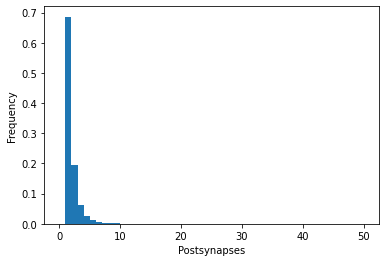

In [63]:
weights = np.ones_like(counts_post) / len(counts_post)
plt.hist(counts_post,range=[0,50],bins=50,weights=weights)
plt.xlabel('Postsynapses')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

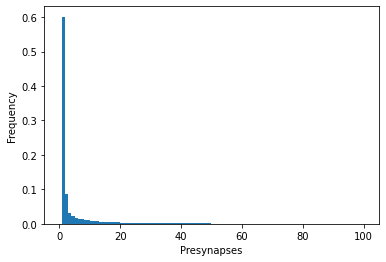

In [64]:
weights = np.ones_like(counts_pre) / len(counts_pre)
plt.hist(counts_pre,range=[0,100],bins=100,weights=weights)
plt.xlabel('Presynapses')
plt.ylabel('Frequency')

## Get neurons of interest

In [ ]:
client.annotation.get_tables()
table = schema_download.download_annotation_table(client,'T1MN_somas')
table_mat = schema_download.generate_soma_table(table,token=tokens['dev'])

In [295]:
def get_partner_synapses(root_id,df,direction='inputs',threshold=None):
    if direction == 'inputs':
        to_find = 'post_id'
        to_threshold = 'pre_id'
        
    elif direction == 'outputs':
        to_find = 'pre_id'   
        to_threshold = 'post_id'
    
    partners = df.loc[df[to_find]==root_id]
        
    if threshold is not None:
        counts = partners[to_threshold].value_counts()
        t_idx = counts >= threshold
        
        partners = partners[partners[to_threshold].isin(set(t_idx.index[t_idx==1]))]

    
    return(partners)

    

In [178]:
#table = schema_download.download_annotation_table(client,'T1MN_somas')
table_mat = schema_download.generate_soma_table(table,token=tokens['dev'],segmentation_version='Dynamic_V4')











Downloading:   0%|          | 0/1 [00:00<?, ?it/s]










Downloading:   0%|          | 0/1 [00:00<?, ?it/s]











Downloading:   0%|          | 0/1 [00:00<?, ?it/s]












Downloading:   0%|          | 0/1 [00:00<?, ?it/s]









Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]











Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]










Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]












Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]













Downloading:   0%|          | 0/1 [00:00<?, ?it/s]














Downloading:   0%|          | 0/1 [00:00<?, ?it/s]















Downloading:   0%|          | 0/1 [00:00<?, ?it/s]















Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]














Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
















Downloading:   0%|          | 0/1 [00:00<?, ?it/s]













Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.38

HTTPError: 403 Client Error: Forbidden for url: https://wclee.dev.zetta.ai/segmentation/api/v1/table/vnc1_full_v3align_2_v4/roots_binary

In [294]:
get_partner_synapses(648518346506628254,df,direction='inputs',threshold=4)

,index,post_id,pre_pt,post_pt,source,pre_id
60226,60284,648518346506628254,[ 58473 101679 3596],[ 58507 101689 3596],29124-29636_50680-51192_3504-3632,648518346484282890
60227,60285,648518346506628254,[ 58483 101665 3596],[ 58521 101661 3596],29124-29636_50680-51192_3504-3632,648518346484282890
60231,60289,648518346506628254,[ 58491 101655 3551],[ 58525 101629 3552],29124-29636_50680-51192_3504-3632,648518346508665047
137003,137185,648518346506628254,[ 59525 110455 2098],[ 59505 110435 2098],29636-30148_54776-55288_2096-2224,648518346514709073
163970,164186,648518346506628254,[56263 93701 2657],[56237 93711 2657],28100-28612_46584-47096_2608-2736,648518346487462154
...,...,...,...,...,...,...
11444277,11469557,648518346506628254,[51313 95019 2587],[51317 95051 2587],25540-26052_47096-47608_2480-2608,648518346525997338
11444396,11469676,648518346506628254,[51463 95075 2596],[51453 95043 2597],25540-26052_47096-47608_2480-2608,648518346494526823
11444406,11469686,648518346506628254,[51465 95071 2597],[51457 95037 2598],25540-26052_47096-47608_2480-2608,648518346494526823
11444820,11470100,648518346506628254,[51863 94975 2580],[51839 94957 2581],25540-26052_47096-47608_2480-2608,648518346526052634


In [160]:
c = inputs.pre_id.value_counts()
threshold = c>1
for index,item in threshold.items():
    inputs = inputs[inputs.]
    if item is False:
        inputs = inputs.drop(inputs.pre_id == index,inplace=True)

KeyError: '[False False False False False False False False False False False False\n False False  True False False False False False] not found in axis'

In [278]:
df.loc[df['pre_id'] == 648518346506628254]

,index,post_id,pre_pt,post_pt,source,pre_id
175369,175586,648518346506628254,[ 64831 101817 3318],[ 64841 101821 3318],32196-32708_50680-51192_3248-3376,648518346506628254
872920,874295,648518346506628254,[ 62221 108091 2339],[ 62213 108099 2340],30660-31172_53752-54264_2224-2352,648518346506628254
872958,874333,648518346349044803,[ 62229 108107 2340],[ 62245 108111 2340],30660-31172_53752-54264_2224-2352,648518346506628254
971921,973476,648518346417920647,[63613 96295 2604],[63599 96321 2604],31684-32196_48120-48632_2480-2608,648518346506628254
1222969,1224884,648518346483991818,[58401 89071 2941],[58395 89109 2942],29124-29636_44536-45048_2864-2992,648518346506628254
...,...,...,...,...,...,...
11294692,11319617,648518346482784778,[ 56419 103151 2309],[ 56415 103185 2309],28100-28612_51192-51704_2224-2352,648518346506628254
11294701,11319626,648518346412129072,[ 56417 103141 2307],[ 56411 103165 2306],28100-28612_51192-51704_2224-2352,648518346506628254
11294721,11319646,648518346412157744,[ 56441 103155 2308],[ 56453 103187 2309],28100-28612_51192-51704_2224-2352,648518346506628254
11294723,11319648,648518346412063536,[ 56445 103141 2307],[ 56455 103165 2306],28100-28612_51192-51704_2224-2352,648518346506628254


648518346508665047     True
648518346516362455     True
648518346511487825     True
648518346525997338     True
648518346487462154     True
                      ...  
648518346387708608    False
648518346481727498    False
648518346506750366    False
648518346480436389    False
648518346506816670    False
Name: pre_id, Length: 285, dtype: bool

339434

In [168]:
fast_inputs = get_partner_synapses(648518346506705566,df,direction='inputs')
fast_counts = fast_inputs.pre_id.value_counts()

In [169]:
slow_inputs = get_partner_synapses(648518346506628254,df,direction='inputs')
slow_counts = slow_inputs.pre_id.value_counts()

In [172]:
fast_counts = fast_counts[fast_counts > 5]
slow_counts = slow_counts[slow_counts > 5]

In [195]:
len(df)

11481782

In [176]:
fast_counts[fast_counts.index == 648518346506623390]

648518346506623390    22
Name: pre_id, dtype: int64

In [ ]:
to_get = adj.sum(axis=1).sort_values(ascending=False)[0:10].index.values

In [ ]:
meshes = cv.mesh.get(to_get,use_byte_offsets=True)

In [ ]:
m = [trimesh_vtk.mesh_actor(meshes[i],opacity=.75) for i in meshes.keys()]

In [ ]:
trimesh_vtk.render_actors(m)

In [ ]:
idx = 0
for i in m:
    trimesh_vtk.render_actors([i],do_save=True,filename='/Users/brandon/Desktop/top_partners/{}.png'.format(str(idx)))
    idx+=1

In [101]:
import networkx as nx


In [102]:
G=nx.from_pandas_adjacency(adj_s.loc[np.array(adj_s).sum(axis = 0)>1,np.array(adj_s).sum(axis = 0)>1])

IndexError: Boolean index has wrong length: 118 instead of 12931

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
degrees = G.degree() #Dict with Node ID, Degree
nodes = G.nodes()
n_color = np.asarray([degrees[n] for n in nodes])



sc = nx.draw_random(G, nodelist=nodes, node_color=n_color, cmap='viridis',
                            node_size=n_color,width=.1)
# use a log-norm, do not see how to pass this through nx API
# just set it after-the-fact


In [ ]:
np.max(np.array(adj_s))

In [ ]:
df.pre_id.value_counts()

In [110]:
a = {}

In [113]:
a['1']

2

HTTPError: 404 Client Error: Not Found for url: https://api.zetta.ai/wclee/materialize/api/v2/datastack/vnc_v0/versions content: b'404 page not found\n'